# Indeed job analyst


* Crawl job links and collect job post information
* City and job popularity
* Job category and pay
* Correlation with my resume

In [28]:
# Perform the following task once
# download token library
# import nltk
# nltk.download()

## References
* Web Scraping Indeed for Key Data Science Job Skills (https://jessesw.com/Data-Science-Skills/)
* Greg Reda Blog (http://www.gregreda.com/)
* Web Scraping with BeautifulSoup (http://web.stanford.edu/~zlotnick/TextAsData/Web_Scraping_with_Beautiful_Soup.html)
* Coursera Python course (https://www.py4e.com/)


In [29]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib.request  # Website connections
import re # Regular expressions
import string
import ssl # SSL certificate errors

from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of out term counts

from nltk.corpus import stopwords # Filer out stopwords, such as 'the', 'or', 'and'
from nltk.tokenize import word_tokenize

import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline


In [30]:
# Ignore SSL certificate errors
def get_ctx():
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    return ctx

In [31]:
# convert string to upper
def convert_to_upper(string):
    return string.upper()

In [32]:
# Concat list of words
def concat_list(list):
    return '+'.join(list)

In [33]:
# Get site link
def get_site(city = None, province = None, job = None):
    if job is not None:
        if '+' in job:
            final_job = concat_list(job.split()).replace('+','%2B')
        else:    
            final_job = concat_list(job.split())
        
    if province is not None:
        final_province = concat_list(province.split())
        
    if city is not None:
        final_city = concat_list(city.split())
        final_site_list = [BASE_URL, '/jobs?q=', final_job,'&l=', final_city, '%2C+', final_province]
    else:
        final_site_list = [BASE_URL,'/jobs?q=', final_job,'&l=+', final_province ]
    
    return ''.join(final_site_list)


In [34]:
def parse_soup(site):
    try:
        html = urllib.request.urlopen(site, context = get_ctx()).read()
    except:
        return
    return BeautifulSoup(html, 'lxml')

In [35]:
# Parse the html return soup
def parse_html(city = None, province = None, job = None):

    final_site = get_site(city, province, job)
    
    return parse_soup(final_site), final_site

In [36]:
 def is_digit(word):
        try:
            int(word)
            return True
        except ValueError:
            return False

In [37]:
def text_cleaner(site):
    try:
        soup_obj = parse_soup(site)
        for script in soup_obj(['script', 'style']):
            script.extract()
    except:
        return
    # important to add devider between sentence somehow word merged to next line
    text = soup_obj.get_text(',')
    
    lines = (line.strip() for line in text.splitlines())
    # tokenize text into bag of words
    tokenized_docs = [word_tokenize(doc) for doc in lines]
    
    # remove punctuation
    tokenized_docs_no_punctuation = []
    regex = re.compile('[%s]' % re.escape(string.punctuation.replace('-','')))
    for doc in tokenized_docs:
        new_doc = []
        for token in doc:
            new_token = regex.sub(u'', token)
            if not new_token == u'':
                new_doc.append(new_token)
        tokenized_docs_no_punctuation.append(new_doc)
    # get rid of terms aren't words
    # remove stop words
    tokenized_docs_no_stopwords = []
   
    for doc in tokenized_docs_no_punctuation:
        new_words = []
        for word in doc:
            if not word in stopwords.words('english'):
                new_words.append(word)
        tokenized_docs_no_stopwords.append(doc)
    
    final_text = set()
    for doc in tokenized_docs_no_stopwords:
        for word in doc:
            if not is_digit(word):
                final_text.add(word.lower())
        
    return list(final_text)
   

In [38]:
# Parse soup return job numbers
def parse_jobs(soup, final_site):
    num_job_area = soup.find(id = 'searchCount').string.split()
    
    numbers = [n for n in num_job_area if re.match('\d+', n)]
    
    total_num_jobs = int(numbers[2])
    
    num_pages = int(total_num_jobs/20 + 1)
    
    print('There are total', total_num_jobs, 'found in', SEARCH_CITY, 'area.')
    
    job_descriptions = []
    # Loop through search results pages
    for i in range(1, num_pages + 1):
        print('Getting page ' + str(i))
        # Assign multiplier 20 to view the pages
        start_num = str(i * 20)
        current_page = ''.join([final_site, '&start=', start_num])
        
        # loop through pages        
        page_obj = parse_soup(current_page)
        
        # Locate results area
        job_link_area = page_obj.find(id = 'resultsCol')
       
        # locate row area
        job_row_area = job_link_area.find_all('div', attrs={"class": "row"})
        try:
            for row in job_row_area:
                link = row.find('a')
                job_href = link.get('href')
                if job_href is not None:
                    job_url = BASE_URL + job_href
                   
                job_title = link.get('title')
                job_description = text_cleaner(job_url)
                
                if job_description:
                    job_descriptions.append(job_description)
                # pause for before move to next link
                sleep(1)
                
        except:
            return
        
        
    print('Done with collecting the job postings!')
    print('There are', len(job_descriptions), 'jobs successfully found.')
        
    return job_descriptions
    

In [39]:
def plot_job(jobs):
    doc_frequency = Counter()
    [doc_frequency.update(item) for item in jobs]

    program_language_dict = Counter({'R': doc_frequency['r'],
                                    'Python': doc_frequency['python'],
                                    'Java': doc_frequency['java'],
                                    'C++': doc_frequency['c++'],
                                    'Ruby': doc_frequency['ruby'],
                                    'Perl': doc_frequency['perl'],
                                    'Matlab': doc_frequency['matlab'],
                                    'JavaScript': doc_frequency['javascript'],
                                    'Scala': doc_frequency['scala'],
                                    'SPSS': doc_frequency['spss'],
                                    'SAS': doc_frequency['sas']})

    analysis_tool_dict = Counter({'Excel': doc_frequency['excel'],
                                  'Tableau': doc_frequency['tableau'],
                                 'D3.js': doc_frequency['d3.js'],
                                 'SPSS': doc_frequency['spss'],
                                 'D3': doc_frequency['d3'],
                                 'Microstrategy': doc_frequency['microstrategy'],
                                 'Qlik': doc_frequency['qlik']})

    hadoop_dict = Counter({'Hadoop': doc_frequency['hadoop'],
                           'MapReduce': doc_frequency['mapreduce'],
                           'Hive': doc_frequency['hive'],
                           'Shark': doc_frequency['shark'],
                           'Oozie': doc_frequency['oozie'],
                           'ZooKeeper': doc_frequency['zookeeper'],
                           'Flume': doc_frequency['flume'],
                           'Mahout': doc_frequency['mahout']})
    
    database_dict = Counter({'SQL': doc_frequency['sql'],
                            'NoSQL': doc_frequency['nosql'],
                            'HBase': doc_frequency['hbase'],
                            'Cassandra': doc_frequency['cassandra'],
                            'MongoDB': doc_frequency['mongodb'],
                            'Solr': doc_frequency['solr'],
                            'Lucene': doc_frequency['lucene']})
    
    company_dict = Counter({'Microsoft': doc_frequency['microsoft'],
                           'Oracle': doc_frequency['oracle'],
                           'Amazon': doc_frequency['amazon'],
                           'Amazon': doc_frequency['aws'],
                           'Google': doc_frequency['google']})

    # Draw based on overall skills
    overall_skills = (program_language_dict + analysis_tool_dict 
                      + hadoop_dict + database_dict)

    df = pd.DataFrame([overall_skills]).T.reset_index()
    df = df.rename(columns = {'index': 'Term', 0: 'NumPostings'})
    df['PercentPost'] = (df.NumPostings) * 100/len(jobs)
    df.sort_values(['NumPostings'], ascending = False, inplace = True)
    jobPlot = df.plot(x = 'Term', y = 'PercentPost', kind = 'bar',
                      legend = None,
                      title = 'Percentage of Data Scientist Job Ads with a key skill,'
                      + SEARCH_CITY)

    jobPlot.set_ylabel('Percentage Appearing in Job Ads')
    jobFig = jobPlot.get_figure()
    
    # Draw based on company
    
    df_company = pd.DataFrame([company_dict]).T.reset_index()
    df_company = df_company.rename(columns = {'index': 'Brand', 0: 'Postings'})
    df_company['PercentPost'] = (df_company.Postings)*100/len(jobs)
    df_company.sort_values(['Postings'], ascending = False, inplace = True)
    companyPlot = df_company.plot(x = 'Brand', y = 'PercentPost',
                                  kind = 'bar',
                                  legend = None,
                                 title = 'Percentage of Company Job Ads with key brand,'
                                 + SEARCH_CITY)
    companyPlot.set_ylabel('Percentage Appearing in Job Ads')
    companyFig = companyPlot.get_figure()

There are total 36 found in calgary area.
Getting page 1
Getting page 2
Done with collecting the job postings!
There are 33 jobs successfully found.


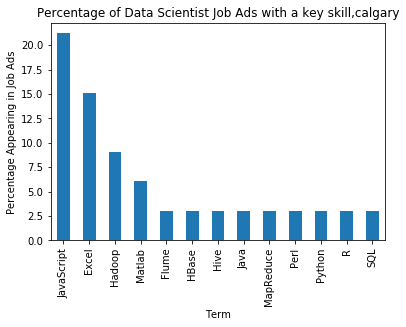

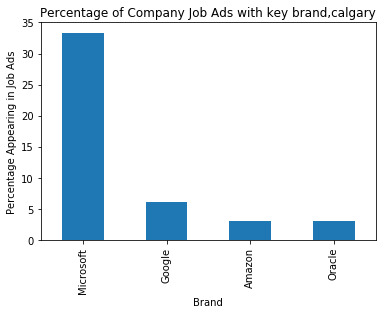

In [40]:
BASE_URL = 'https://www.indeed.ca'
SEARCH_JOB = 'data scientist'
SEARCH_CITY = 'calgary'
SEARCH_PROVINCE = 'ab'

soup, final_site = parse_html(SEARCH_CITY, SEARCH_PROVINCE, SEARCH_JOB)

jobs = parse_jobs(soup, final_site)

plot_job(jobs)

There are total 300 found in toronto area.
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Done with collecting the job postings!
There are 280 jobs successfully found.


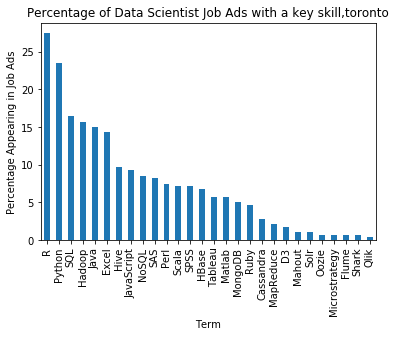

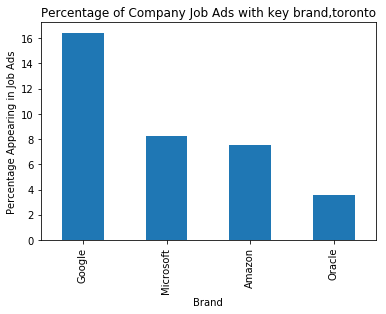

In [41]:
BASE_URL = 'https://www.indeed.ca'
SEARCH_JOB = 'data scientist'
SEARCH_CITY = 'toronto'
SEARCH_PROVINCE = 'on'

soup, final_site = parse_html(SEARCH_CITY, SEARCH_PROVINCE, SEARCH_JOB)

jobs = parse_jobs(soup, final_site)

plot_job(jobs)

There are total 158 found in vancouver area.
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Done with collecting the job postings!
There are 124 jobs successfully found.


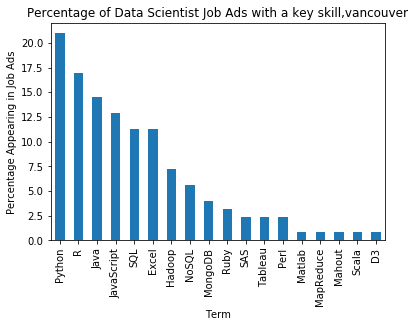

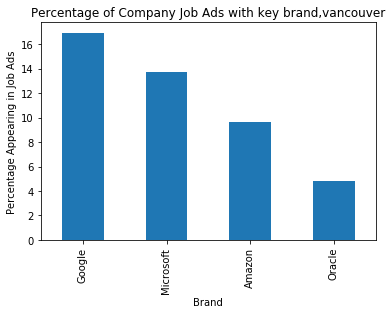

In [42]:
BASE_URL = 'https://www.indeed.ca'
SEARCH_JOB = 'data scientist'
SEARCH_CITY = 'vancouver'
SEARCH_PROVINCE = 'bc'

soup, final_site = parse_html(SEARCH_CITY, SEARCH_PROVINCE, SEARCH_JOB)

jobs = parse_jobs(soup, final_site)

plot_job(jobs)

There are total 24 found in edmonton area.
Getting page 1
Getting page 2
Done with collecting the job postings!
There are 22 jobs successfully found.


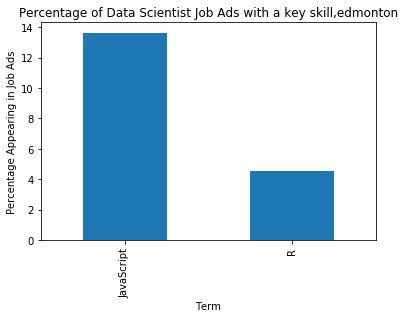

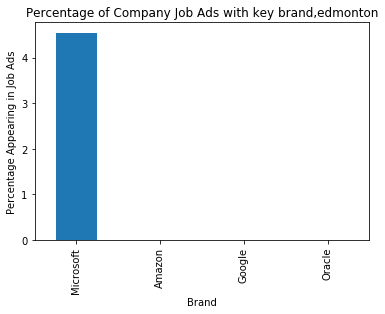

In [43]:
BASE_URL = 'https://www.indeed.ca'
SEARCH_JOB = 'data scientist'
SEARCH_CITY = 'edmonton'
SEARCH_PROVINCE = 'ab'

soup, final_site = parse_html(SEARCH_CITY, SEARCH_PROVINCE, SEARCH_JOB)

jobs = parse_jobs(soup, final_site)

plot_job(jobs)